# 라이브러리

In [1]:
#! pip install -U finance_datareader
import FinanceDataReader as fdr
from datetime import datetime
from datetime import timedelta
import random
import numpy as np
import pandas as pd
# debug
import pdb
#pdb.set_trace()

import xgboost as xgb

from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# colab
#!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
#!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
#!dpkg -i libta.deb ta.deb
#!pip install ta-lib

#local : https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib 에서 다운로드
#!pip install TA_Lib-0.4.19-cp38-cp38-win_amd64.whl
import talib

#시계열 분해
#!pip install stldecompose
from stldecompose import decompose

import matplotlib.pyplot as plt
# matplotlib 한글설정
import matplotlib as mpl
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
f = [f.name for f in fm.fontManager.ttflist]
# 폰트 설정 - 한글 오류(미해결)
path = 'C:/Users/kjy30/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=50)
mpl.rc('font', family=mpl.font_manager.FontProperties(fname=path).get_name())

import seaborn as sns

# 시각화 사용자 설정
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

#사이킷런 warning 숨기기
import warnings
warnings.filterwarnings(action='ignore')

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# 주피터 노트북에서 plotly 사용하기
init_notebook_mode(connected=True)

# 기본 배경색 바꾸기
layout = go.Layout(paper_bgcolor='rgba(0, 0, 0, 0)', plot_bgcolor='rgba(250, 250, 250, 0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

# XGBOOST 
#!pip install graphviz
import graphviz

C:\Users\kjy30\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 함수 정의

In [23]:
# l 안에 있는 종목에 대해 y년 동안의 데이터를 가진 df dictionary 리턴
# l 이 빈 리스트일 경우 랜덤으로 rs개 종목을 가져온다
def makeDataDf(l=[], rs=2, y=6) :
  ndf = fdr.StockListing('KRX')
  dateColNm = 'ListingDate'
  symbolColNm = 'Symbol'
  nameColNm = 'Name'
  ndf3 = pd.DataFrame()
  if l == [] :
    pivotDate = datetime.now() - timedelta(days=y*366)
    ndf2 = ndf[ndf[dateColNm] < pivotDate].loc[:, [symbolColNm, nameColNm]]
    ndf3 = ndf2.sample(n=rs)
  else :
    ndf3 = ndf[ndf[symbolColNm].isin(l)]  
  retDic = {}
  for code in ndf3[symbolColNm] :
    tmpdf = fdr.DataReader(code, str(datetime.today().year - y))
    tmpdf[nameColNm] = ndf3[ndf3[symbolColNm]==code][nameColNm].iloc[0]
    #pdb.set_trace()
    retDic[code] = tmpdf
  return retDic

# talib 을 이용한 technical indicator 구현
def makeTechIndicator_1(df, tp=20) :
    '''
        Overlap Studies Functions
    '''
    
    closeColNm = 'Close'
    highColNm = 'High'
    lowColNm = 'Low'
    
    close = df[closeColNm]
    high = df[highColNm]
    low = df[lowColNm]
    
    # BBANDS - Bollinger Bands
    df['ub'], df['middle'], df['lb'] = talib.BBANDS(close, timeperiod=tp, nbdevup=2, nbdevdn=2, matype=0)
    
    # SMA - Simple Moving average
    df['sma'] = talib.SMA(close, timeperiod=tp)
    
    # EMA - Exponential Moving Average
    df['ema'] = talib.EMA(close, timeperiod=tp)
    
    # DEMA - Double Exponential Moving Average
    df['dema'] = talib.DEMA(close, timeperiod=tp)
    
    # TEMA - Triple Exponential Moving Average
    df['tema'] = talib.TEMA(close, timeperiod=tp)
    
    # TRIMA - Triangular Moving Average
    df['trima'] = talib.TRIMA(close, timeperiod=tp)
    
    # WMA - Weighted Moving Average
    df['wma'] = talib.WMA(close, timeperiod=tp)
    
    # KAMA - Kaufman Adaptive Moving Average
    df['kama'] = talib.KAMA(close, timeperiod=tp)
    
    # MIDPOINT - MidPoint over period
    df['midpoint'] = talib.MIDPOINT(close, timeperiod=tp)
    
    # MIDPRICE - Midpoint Price over period
    df['midprice'] = talib.MIDPRICE(high, low, timeperiod=tp)
    
    # SAR - Parabolic SAR
    df['sar'] = talib.SAR(high, low, acceleration=0, maximum=0)
    
    # SAREXT - Parabolic SAR - Extended
    df['sarext'] = talib.SAREXT(high, low, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
    
     # HT_TRENDLINE - Hilbert Transform - Instantaneous Trendline
    df['httl'] = talib.HT_TRENDLINE(close)
    return df

# talib 을 이용한 technical indicator 구현
def makeTechIndicator_2(df) :
    '''
    Momentum Indicator Functions
    '''
    closeColNm = 'Close'
    highColNm = 'High'
    lowColNm = 'Low'
    volumeColNm = 'Volume'
    openColNm = 'Open'
    
    open = df[openColNm]
    close = df[closeColNm]
    high = df[highColNm]
    low = df[lowColNm]
    volume = df[volumeColNm]
    
    # ADX - Average Directional Movement Index
    df['adx'] = talib.ADX(high, low, close, timeperiod=14)
    
    # ADXR - Average Directional Movement Index Rating 
    df['adxr'] = talib.ADXR(high, low, close, timeperiod=14)
    
    # APO - Absolute Price Oscillator
    df['apo'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    
    # AROON - Aroon
    df['aroondown'], df['aroonup'] = talib.AROON(high, low, timeperiod=14)
    
    # AROONOSC - Aroon Oscillator
    df['arronosc'] = talib.AROONOSC(high, low, timeperiod=14)
    
    # BOP - Balance Of Power
    df['bop'] = talib.BOP(open, high, low, close)
    
    # CCI - Commodity Channel Index
    df['cci'] = talib.CCI(high, low, close, timeperiod=14)
    
    # CMO - Chande Momentum Oscillator
    df['cmo'] = talib.CMO(close, timeperiod=14)
    
    # DX - Directional Movement Index
    df['dx'] = talib.DX(high, low, close, timeperiod=14)
    
    # MACD - Moving Average Convergence/Divergence
    df['macd'], df['macdsignal'], df['macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    
    # MACDEXT - MACD with controllable MA type
    df['macdext'], df['macdsignalext'], df['macdhistext'] = talib.MACDEXT(close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
    
    # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
    df['macdfix'], df['macdsignalfix'], df['macdhistfix'] = talib.MACDFIX(close, signalperiod=9)
    
    # MFI - Money Flow Index
    df['mfi'] = talib.MFI(high, low, close, volume, timeperiod=14)
    
    # MINUS_DI - Minus Directional Indicator
    df['minus_di'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    
    # MINUS_DM - Minus Directional Movement
    df['minus_dm'] = talib.MINUS_DM(high, low, timeperiod=14)
    
    # MOM - Momentum
    df['mom'] = talib.MOM(close, timeperiod=10)
    
    # PLUS_DI - Plus Directional Indicator
    df['plus_di'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    
    # PLUS_DM - Plus Directional Movement
    df['plus_dm'] = talib.PLUS_DM(high, low, timeperiod=14)
    
    # PPO - Percentage Price Oscillator
    df['ppo'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    
    # ROC - Rate of change : ((price/prevPrice)-1)*100
    df['roc'] = talib.ROC(close, timeperiod=10)
    
    # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
    df['rocp'] = talib.ROCP(close, timeperiod=10)
    
    # ROCR - Rate of change ratio: (price/prevPrice)
    df['rocr'] = talib.ROCR(close, timeperiod=10)
    
    # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
    df['rocr100'] = talib.ROCR100(close, timeperiod=10)
    
    # RSI - Relative Strength Index
    df['rsi'] = talib.RSI(close, timeperiod=14)
    
    # STOCH - Stochastic
    df['stoch_slowk'], df['stoch_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    
    # STOCHF - Stochastic Fast
    df['stochf_fastk'], df['stochf_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    
    # STOCHRSI - Stochastic Relative Strength Index
    df['stochrsi_fastk'], df['stochrsi_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    
    # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
    df['trix'] = talib.TRIX(close, timeperiod=30)
    
    # ULTOSC - Ultimate Oscillator
    df['ultosc'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    
    # WILLR - Williams' %R
    df['willr'] = talib.WILLR(high, low, close, timeperiod=14)
    return df

def makeTechIndicator_3(df) :
    '''
    Volume Indicator Functions
    '''
    closeColNm = 'Close'
    highColNm = 'High'
    lowColNm = 'Low'
    volumeColNm = 'Volume'
    
    close = df[closeColNm]
    high = df[highColNm]
    low = df[lowColNm]
    volume = df[volumeColNm]
    
    # AD - Chaikin A/D Line
    df['ad'] = talib.AD(high, low, close, volume)
    
    # ADOSC - Chaikin A/D Oscillator
    df['adosc'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    
    # OBV - On Balance Volume
    df['obv'] = talib.OBV(close, volume)
    return df

def makeKC(df, rtnColNm='Change') :
    closeColNm = 'Close'
    # 켈리의 법칙 : 평균 수익률 - 무위험 비율(0으로 고정) / 변동성^2
    # KC가 높을수록 수익도 커지고 위험도 증가
    #df['rtn'] = df[closeColNm].pct_change()
    mu = df[rtnColNm].mean() * 252 # 1년 252일로 계산
    sigma = df[rtnColNm].std() * 252 ** 0.5
    r = 0 # 무위험 비율 - 은행 이자 등
    f = (mu - r) / sigma ** 2
    return f

def makeOutput(df, colNm='Change', method='binary', pivot=0.02) :
    # output을 계산하여 넣는다
    # method 가 binary 면 이항분류로, 아니면 값 예측으로 넣는다(기존칼럼값)
    if method == 'binary' :
        def func(col, p) :
            if col > p :
                return 1
            else :
                return 0
        df['pre_output'] = df.apply(lambda x : func(x[colNm], pivot), axis=1)
    else :
        df.rename(columns={colNm:'pre_output'}, inplace=True)
    df['output'] = df['pre_output'].shift(-1)
    return df

# OHLC, 거래량 그래프 그리기
def lineGraph_ohlc(df) :
    name = f"{df.loc[:, 'Name'].iloc[0]}"
    
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Ohlc(x=df.index, open=df.Open, high=df.High, low=df.Low, close=df.Close, name=name + ' Price'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.Volume, name=name + ' Volume'), row=2, col=1)

    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()
    
# 시계열 데이터 분해해주는 함수
def arima_decompose(df) :
    decomp = decompose(df.Close, period=365)
    fig = decomp.plot()
    fig.set_size_inches(30, 15)
    
# 여러개 한꺼번에 라인 그래프 그리기
def linegraph_multi(mlist, df, xlim=[], ylim=[]) :    
    ax = df[mlist].plot(title=f"{df.loc[:, 'Name'].iloc[0]}", legend=True, figsize=(30, 20))
    ax.set_xlabel('date')
    ax.set_ylabel('')
    ax.legend(mlist, fontsize=20)
    if xlim != [] :
        ax.set_xlim(xlim)
    if ylim != [] :
        ax.set_ylim(ylim)
        
# 히스토그램을 사용한 평균 변화율 확인하기
def histo(df, colNm='rtn') :
    plt.figure(figsize=(10, 10))
    sns.distplot(df[colNm].dropna(), bins=100, color='purple')
    plt.ylabel(colNm)
    plt.title(f"{df.loc[:, 'Name'].iloc[0]}")
    
# 결측치 찾기 - inf 는 이상치로 다룬다
def missingVal(df) :
    print(f'missingVal : {df.isnull().sum()}')
    
# 결측치 처리
def dataImputation(df, method='drop') :
    if method == 'drop' :
        return df.dropna(inplace=True)
    elif method == 'ffill' :
        return df.fillna(method='ffill', inplace=True)
    # look-ahead bias
    elif method == 'bfill' :
        return df.fillna(method='bfill', inplace=True)
    elif method == 'mean' :
        return df.fillna(df.mean(), inplace=True)

def simpleCorr(col1, col2, df) :
    sns.jointplot(col1, col2, df, kind='scatter')
    return

def corrGrid(df) :
    # PairGrid 라는 함수를 사용해서, 위/아래/대각선에 어떤 그래프를 보여줄 것인지 설정할 수 있다
    return_fig = sns.PairGrid(df.dropna())
    return_fig.map_upper(plt.scatter, color='purple')
    # KDE : 커널 밀도 추정, 히스토그램 분포를 스무딩하게 표현
    return_fig.map_lower(sns.kdeplot, cmap='cool_d')
    return_fig.map_diag(plt.hist, bins=30)
    return

def corrHeatMap(df, method='pearson') :    
    fig, ax = plt.subplots(figsize=(30,30))
    smap = sns.heatmap(df.corr(method=method), annot=True, cmap='summer', ax=ax)
    smap.set_xticklabels(smap.get_xmajorticklabels(), fontsize=30)
    smap.set_yticklabels(smap.get_ymajorticklabels(), fontsize=30)
    return

# boxplot 으로 col1-output 비교
def corrBox(df, col1, output='output') :
    sns.boxplot(x=col1, y=output, data=df)
    return

# 이상치 찾기 및 바꾸기 - IQR (1/4분위수 사용)
# 평균과 표준편차를 이용하는 z-score라는 방법도 있다
# def outlier(df, col, z):
#    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z].index
def outlier(df, colNm, indexPrint=True, drop=False) :
    # 무한대 값을 max/min 으로 바꾸기
    m = df.loc[df[colNm] != np.inf, colNm].max()
    df[colNm].replace(np.inf, m, inplace=True)
    m = df.loc[df[colNm] != -np.inf, colNm].min()
    df[colNm].replace(-np.inf, m, inplace=True)
    
    # IQR
    outputColNm = 'output'
    '''
    for output in outputlist :
        data = df[df[outputColNm] == output][colNm]
        quan_25 = np.percentile(data.values, 25)
        quan_75 = np.percentile(data.values, 75)
        iqr = quan_75 - quan_25
        iqr = iqr * 1.5
        lowest = quan_25 - iqr
        highest = quan_75 + iqr
        outlier_index = data[(data < lowest) | (data > highest)].index
        # index print
        if(indexPrint) :
            print(f'outlier index length (output : {output}, colNm : {colNm}) : {len(outlier_index)}')
        # outlier drop
        if(drop) :
            df.drop(outlier_index, axis=0, inplace=True)
            print(f'df shape : {df.shape}')
    '''
    data = df[colNm]
    quan_25 = np.percentile(data.values, 25)
    quan_75 = np.percentile(data.values, 75)
    iqr = quan_75 - quan_25
    iqr = iqr * 1.5
    lowest = quan_25 - iqr
    highest = quan_75 + iqr
    outlier_index = data[(data < lowest) | (data > highest)].index
    # index print
    if(indexPrint) :
        print(f'outlier index length (colNm : {colNm}) : {len(outlier_index)}')
    # outlier drop
    if(drop) :
        df.drop(outlier_index, axis=0, inplace=True)
        print(f'df shape : {df.shape}')
    return df

# 정규화 : 이상치 처리 후 진행
def scaler(df, sname='robust') :
    if sname == 'robust' :
        robustScaler = RobustScaler()
        robustScaler.fit(df)
        df_robustScaled = robustScaler.transform(df)
        return df_robustScaled
    elif sname == 'minmax' :
        minMaxScaler = MinMaxScaler()
        minMaxScaler.fit(df)
        df_minMaxScaled = minMaxScaler.transform(df)
        return df_minMaxScaled
    elif sname == 'standard' :
        standardScaler = StandardScaler()
        standardScaler.fit(df)
        df_standardScaled = standardScaler.transform(df)
        return df_standardScaled
    
# 분할 - 1 비율 (가장 기본)
def dataSplitPercent(df, tsize=0.15, vsize=0.15, drawGraph=True) : 
    test_size = tsize
    valid_size = vsize

    test_split_idx = int(df.shape[0] * (1 - test_size)) # 85%
    valid_split_idx = int(df.shape[0] * (1 - (valid_size + test_size))) # 70%

    train_df = df.iloc[:valid_split_idx].copy()
    valid_df = df.iloc[valid_split_idx + 1:test_split_idx].copy()
    test_df = df.iloc[test_split_idx + 1:].copy()
    
    outputColNm = "output"
    if(drawGraph) :
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=train_df.index, y=train_df[outputColNm], name='Training'))
        fig.add_trace(go.Scatter(x=valid_df.index, y=valid_df[outputColNm], name='Validation'))
        fig.add_trace(go.Scatter(x=test_df.index, y=test_df[outputColNm], name='Test'))
        fig.show()
    return train_df, test_df, valid_df

# 분할 - 2 시간

# 분할 - 3 cross-validation 기법

# XGBoost
def xgBoostGridSearch(trainTuple, validTuple, paramDic, colNmList, obj='reg:squarederror') :
    parameters = {
        'booster' :['gbtree'],
        'learning_rate':paramDic['learning_rate'],
        'n_estimators':paramDic['n_estimators'],
        'max_depth':paramDic['max_depth'],
        'gamma':paramDic['gamma'],
        'random_state':paramDic['random_state'],
        #'early_stoppings':paramDic['early_stoppings']
    }
    cv=TimeSeriesSplit(n_splits=5)
    #eval_set = [trainTuple, validTuple]
    # objective : 목적함수. 이 함수를 통해 나온 값이 최소화되는 방향으로 학습된다.
    # binary:logistic : 이항 분류(binary class)에 사용
    # multi:softmax / multi:softprob : 다항 분류(multi class)에 사용.
    if obj == 'binary:logistic' :
        model = xgb.XGBClassifier(objective=obj)
    else :
        model = xgb.XGBRegressor(objective=obj)
    
    clf = GridSearchCV(model, parameters, cv=cv)
    
    dtrain = pd.DataFrame(trainTuple[0], columns=colNmList)
    clf.fit(dtrain, trainTuple[1])
    print(f'Best params : {clf.best_params_}')
    print(f'Best validation score = {clf.best_score_}')
    return clf

def xgBoost(clf, trainTuple, validTuple, colNmList, obj='reg:squarederror', fiGraph=True) :
    dtrain = pd.DataFrame(trainTuple[0], columns=colNmList)
    dvalid = pd.DataFrame(validTuple[0], columns=colNmList)
    #eval_set = [(dtrain, trainTuple[1]), (dvalid, validTuple[1])]
    eval_set = [(dvalid, validTuple[1])]
    
    if obj == 'binary:logistic' :
        model = xgb.XGBClassifier(**clf.best_params_, objective=obj)
    else :
        model = xgb.XGBRegressor(**clf.best_params_, objective=obj)
    
    model.fit(dtrain, trainTuple[1], eval_set=eval_set, verbose=False)
    model.get_booster().get_score(importance_type='weight')
    
    if fiGraph :
        plot_importance(model)
        
    return model

def pred(model, testTuple, df, test_df, colNmList, colNm='output') :
    dtrain = pd.DataFrame(trainTuple[0], columns=colNmList)
    dtest = pd.DataFrame(testTuple[0], columns=colNmList)
    y_pred = model.predict(dtest)
    print(f'mean_squared_error = {mean_squared_error(testTuple[1], y_pred)}')

    # 예측값과 실제값 그려보기
    predicted_prices = test_df.copy()
    predicted_prices[colNm] = y_pred

    fig = make_subplots(rows=2, cols=1)

    fig.add_trace(go.Scatter(x=df.index, y=df[colNm], name='Truth', marker_color='LightSkyBlue'), row=1, col=1)
    fig.add_trace(go.Scatter(x=predicted_prices.index, y=predicted_prices[colNm], name='Prediction', marker_color='MediumPurple'), row=1, col=1)

    fig.add_trace(go.Scatter(x=predicted_prices.index, y=testTuple[1], name='Truth', marker_color='LightSkyBlue', showlegend=False), row=2, col=1)
    fig.add_trace(go.Scatter(x=predicted_prices.index, y=y_pred, name='Prediction', marker_color='MediumPurple', showlegend=False), row=2, col=1)

    fig.show()
    
# Random Forest

# LSTM

# 시나리오

In [8]:
# 1. 예측할 종목을 랜덤으로 가져온다
dic = makeDataDf(l=['005930'], rs=1, y=10)

In [9]:
# 2. 뽑아온 종목 확인
print(dic.keys())

dict_keys(['005930'])


In [10]:
# 2.5 OHLC 그래프 확인
for key, values in dic.items() :
    lineGraph_ohlc(dic[key])

In [ ]:
# 2.5 시계열 분해
#for key, values in dic.items() :
#    arima_decompose(dic[key])

In [11]:
# 3. 기술지표와 output 넣은 df 만들기 및 결측치 처리
outputColNm = 'output'
dic_bin = {}
dic_reg = {}
for code, df in dic.items() :
    # 지표 생성 전 결측치 처리
    tmp_df1 = df.copy()
    missingVal(tmp_df1)
    dataImputation(tmp_df1, 'ffill')
    
    tmp_df2 = df.copy()
    missingVal(tmp_df2)
    dataImputation(tmp_df2, 'ffill')
    
    tmp_df3 = df.copy()
    missingVal(tmp_df3)
    dataImputation(tmp_df3, 'ffill')
    
    df_bin = makeOutput(makeTechIndicator_3(makeTechIndicator_2(makeTechIndicator_1(tmp_df1))), pivot=0.005)
    df_reg = makeOutput(makeTechIndicator_3(makeTechIndicator_2(makeTechIndicator_1(tmp_df2))), method='reg')
    df = makeTechIndicator_3(makeTechIndicator_2(makeTechIndicator_1(tmp_df3)))

    # 지표 생성 후 결측치 처리
    missingVal(df_bin)
    dataImputation(df_bin, 'drop')
    missingVal(df_reg)
    dataImputation(df_reg, 'drop')
    missingVal(df)
    dataImputation(df_reg, 'drop')
    
    name = df.loc[:, 'Name'].iloc[0]
    dic_bin[code] = df_bin
    dic_reg[code] = df_reg
    dic[code] = df
    # 4. 종목 별 (수익률 / 변동성) 확인
    print(f'{name} KC value : {makeKC(df_reg, outputColNm)}')

missingVal : Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
Name      0
dtype: int64
missingVal : Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
Name      0
dtype: int64
missingVal : Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
Name      0
dtype: int64
missingVal : Open          0
High          0
Low           0
Close         0
Volume        0
             ..
ad            0
adosc         9
obv           0
pre_output    0
output        1
Length: 67, dtype: int64
missingVal : Open       0
High       0
Low        0
Close      0
Volume     0
          ..
willr     13
ad         0
adosc      9
obv        0
output     1
Length: 66, dtype: int64
missingVal : Open       0
High       0
Low        0
Close      0
Volume     0
          ..
ultosc    28
willr     13
ad         0
adosc      9
obv        0
Length: 65, dtype: int64
삼성전자 KC value : 2.464595641313188


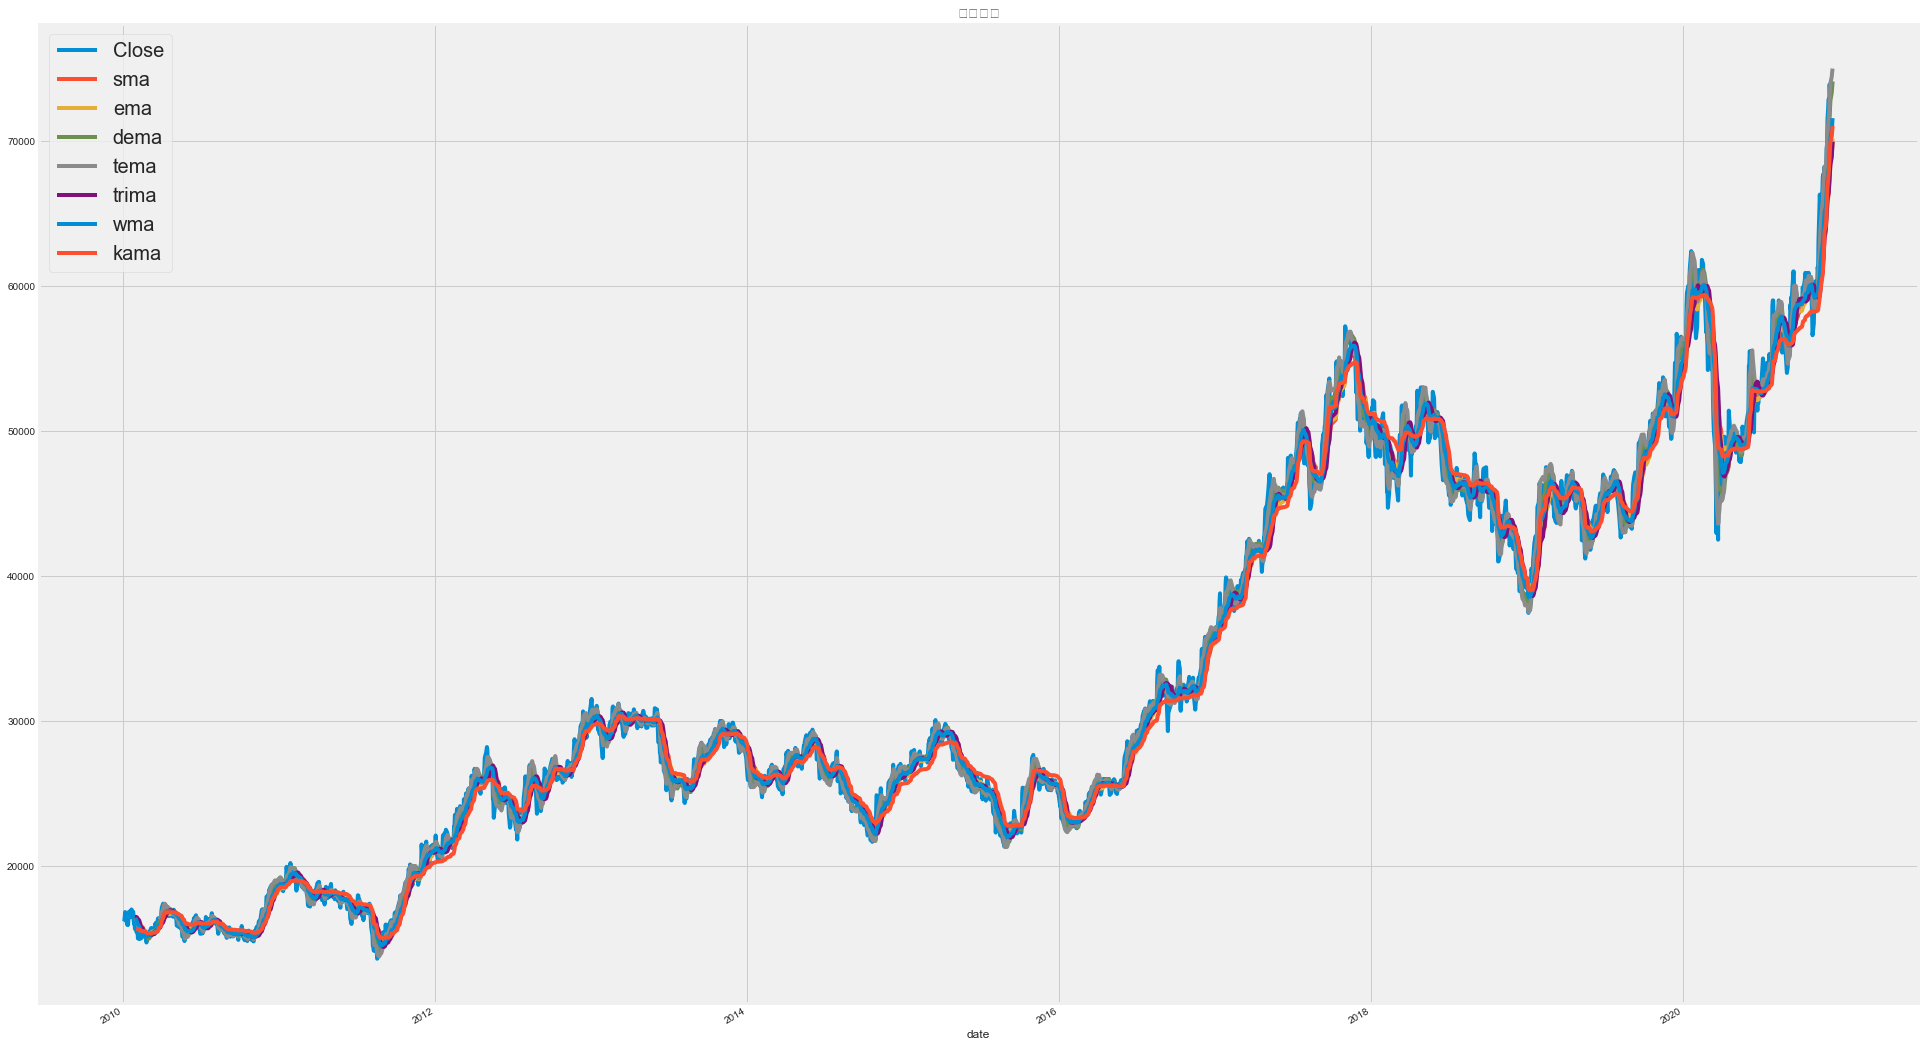

In [12]:
# 3.5 이동평균 그래프
malist = ['Close', 'sma', 'ema', 'dema', 'tema', 'trima', 'wma', 'kama']
for code, df in dic.items() :
    linegraph_multi(malist, dic[code])

# binary 로 예측하기

In [ ]:
# 3.5 output(변화율) 값 분포 확인
for code, df in dic_bin.items() :
    histo(dic_bin[code], outputColNm)
    print(dic_bin[code][outputColNm].value_counts())

In [ ]:
# y 값 분포 조절
outputColNm = 'output'
for code, df in dic_bin.items() :
    df_bin = makeOutput(tmp_df1, pivot=0)

    # 지표 생성 후 결측치 처리
    missingVal(df_bin)
    dataImputation(df_bin, 'drop')

    name = df_bin.loc[:, 'Name'].iloc[0]
    dic_bin[code] = df_bin

for code, df in dic_bin.items() :
    histo(dic_bin[code], outputColNm)
    print(dic_bin[code][outputColNm].value_counts())

In [ ]:
# 4. 관계 확인 - bin
# 그래프
#for code, df in dic_bin.items() :
    # corrHeatMap(df)
    #corrHeatMap(df, 'spearman')
    # corrHeatMap(df, 'kendall')
    
# output 과는 관계있는게 없어서 pre_output 으로 확인
for code, df in dic_bin.items() :
    tmp_df = df.copy()
    corr = tmp_df.corr(method='spearman')
    print(corr[corr['pre_output'] > 0.5])

In [ ]:
# 4.5 output과 상관관계가 높은 칼럼 목록 정의    
corrColList = ['bop', 'stochrsi_fastk']

In [ ]:
# 4.5 다중공선성 문제 - feature 사이의 관계 찾기 및 처리
for code, df in dic.items() :
    tmp_df = df.loc[:, corrColList].copy()
    corrHeatMap(tmp_df)

In [ ]:
# feature 와 output 과의 상관관계 확인 - bin
addlist = corrColList.copy()
addlist.append('output')

for code, df in dic_bin.items() :
    tmp_df = dic_bin[code].loc[:, addlist].copy()
    simpleCorr(corrColList[0], corrColList[1], tmp_df)
    corrGrid(tmp_df)

In [ ]:
# 5. output 과의 관계가 높은 칼럼에 대해 이상치 찾기 - bin
for code, df in dic_bin.items() :
    # 5.5 output 과의 관계가 낮은 칼럼 제거
    df = df.loc[:, addlist]
    dic_bin[code] = df
    for col in corrColList :
        # 이상치를 제거하려면 drop=True 옵션 사용
        outlier(df, col, drop=False)

In [ ]:
# 이항 분류 (bin)
for code, df in dic_bin.items() :
    # 6. test-train 분리
    train_df, test_df, valid_df = dataSplitPercent(df)

    # 7. X, y 분리 및 데이터 정규화
    y_train = train_df[outputColNm].copy()
    X_train = scaler(train_df.drop([outputColNm], 1))
    trainTuple = (X_train, y_train)
    
    y_valid = valid_df[outputColNm].copy()
    X_valid = scaler(valid_df.drop([outputColNm], 1))
    validTuple = (X_valid, y_valid)

    y_test = test_df[outputColNm].copy()
    X_test = scaler(test_df.drop([outputColNm], 1))
    testTuple = (X_test, y_test)

    # 8. XGBoost 학습, feature importance 로 중요한 feature 찾기
    paramDic = {}
    paramDic['n_estimators'] = [100, 200]
    paramDic['max_depth'] = [3, 4, 5]
    paramDic['gamma'] = [0, 1, 2, 3]
    paramDic['random_state'] = [50]
    paramDic['learning_rate'] = [0.005, 0.01, 0.05, 0.1, 0.2]

    binaryObj = 'binary:logistic'
    clf = xgBoostGridSearch(trainTuple, validTuple, paramDic, corrColList, obj=binaryObj)
    model = xgBoost(clf, trainTuple, validTuple, corrColList, obj=binaryObj)

    # 9. 예측
    pred(model, testTuple, df, test_df, corrColList)

# regression 으로 예측하기

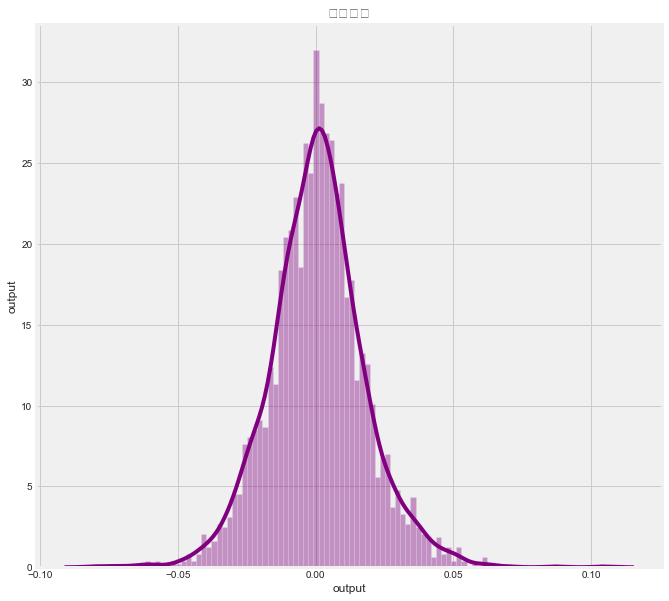

In [13]:
# 3.5 output(변화율) 값 분포 확인
for code, df in dic_reg.items() :
    tmp_df = dic_reg[code].copy()
    histo(dic_reg[code], outputColNm)

In [14]:
# 4. 관계 확인 - reg
# 그래프 그리기
#for code, df in dic_reg.items() :
    # corrHeatMap(df)
    #corrHeatMap(df, 'spearman')
    # corrHeatMap(df, 'kendall')

# output 과는 관계있는게 없어서 pre_output 으로 확인
for code, df in dic_reg.items() :
    tmp_df = df.copy()
    corr = tmp_df.corr(method='spearman')
    print(corr[corr['pre_output'] > 0.5])

                    Open      High       Low     Close    Volume  pre_output  \
pre_output      0.015051  0.031153  0.032062  0.051369 -0.010155    1.000000   
bop            -0.001806  0.020630  0.020773  0.042933 -0.013262    0.726973   
stochf_fastk    0.049823  0.059079  0.061351  0.082593 -0.047975    0.663344   
stochrsi_fastk  0.009555  0.018969  0.021447  0.040164 -0.049518    0.721131   

                      ub    middle        lb       sma  ...  stochf_fastd  \
pre_output      0.003308  0.002582  0.002673  0.002582  ...      0.213117   
bop             0.005446  0.003766  0.003425  0.003766  ...      0.186359   
stochf_fastk   -0.001317 -0.003244 -0.004566 -0.003244  ...      0.777733   
stochrsi_fastk -0.018759 -0.019481 -0.020043 -0.019481  ...      0.573913   

                stochrsi_fastk  stochrsi_fastd      trix    ultosc     willr  \
pre_output            0.721131        0.251033  0.007026  0.244852  0.460843   
bop                   0.522689        0.164434  0.029

In [15]:
# 4.5 output과 상관관계가 높은 칼럼 목록 정의    
corrColList = ['bop', 'stochrsi_fastk']

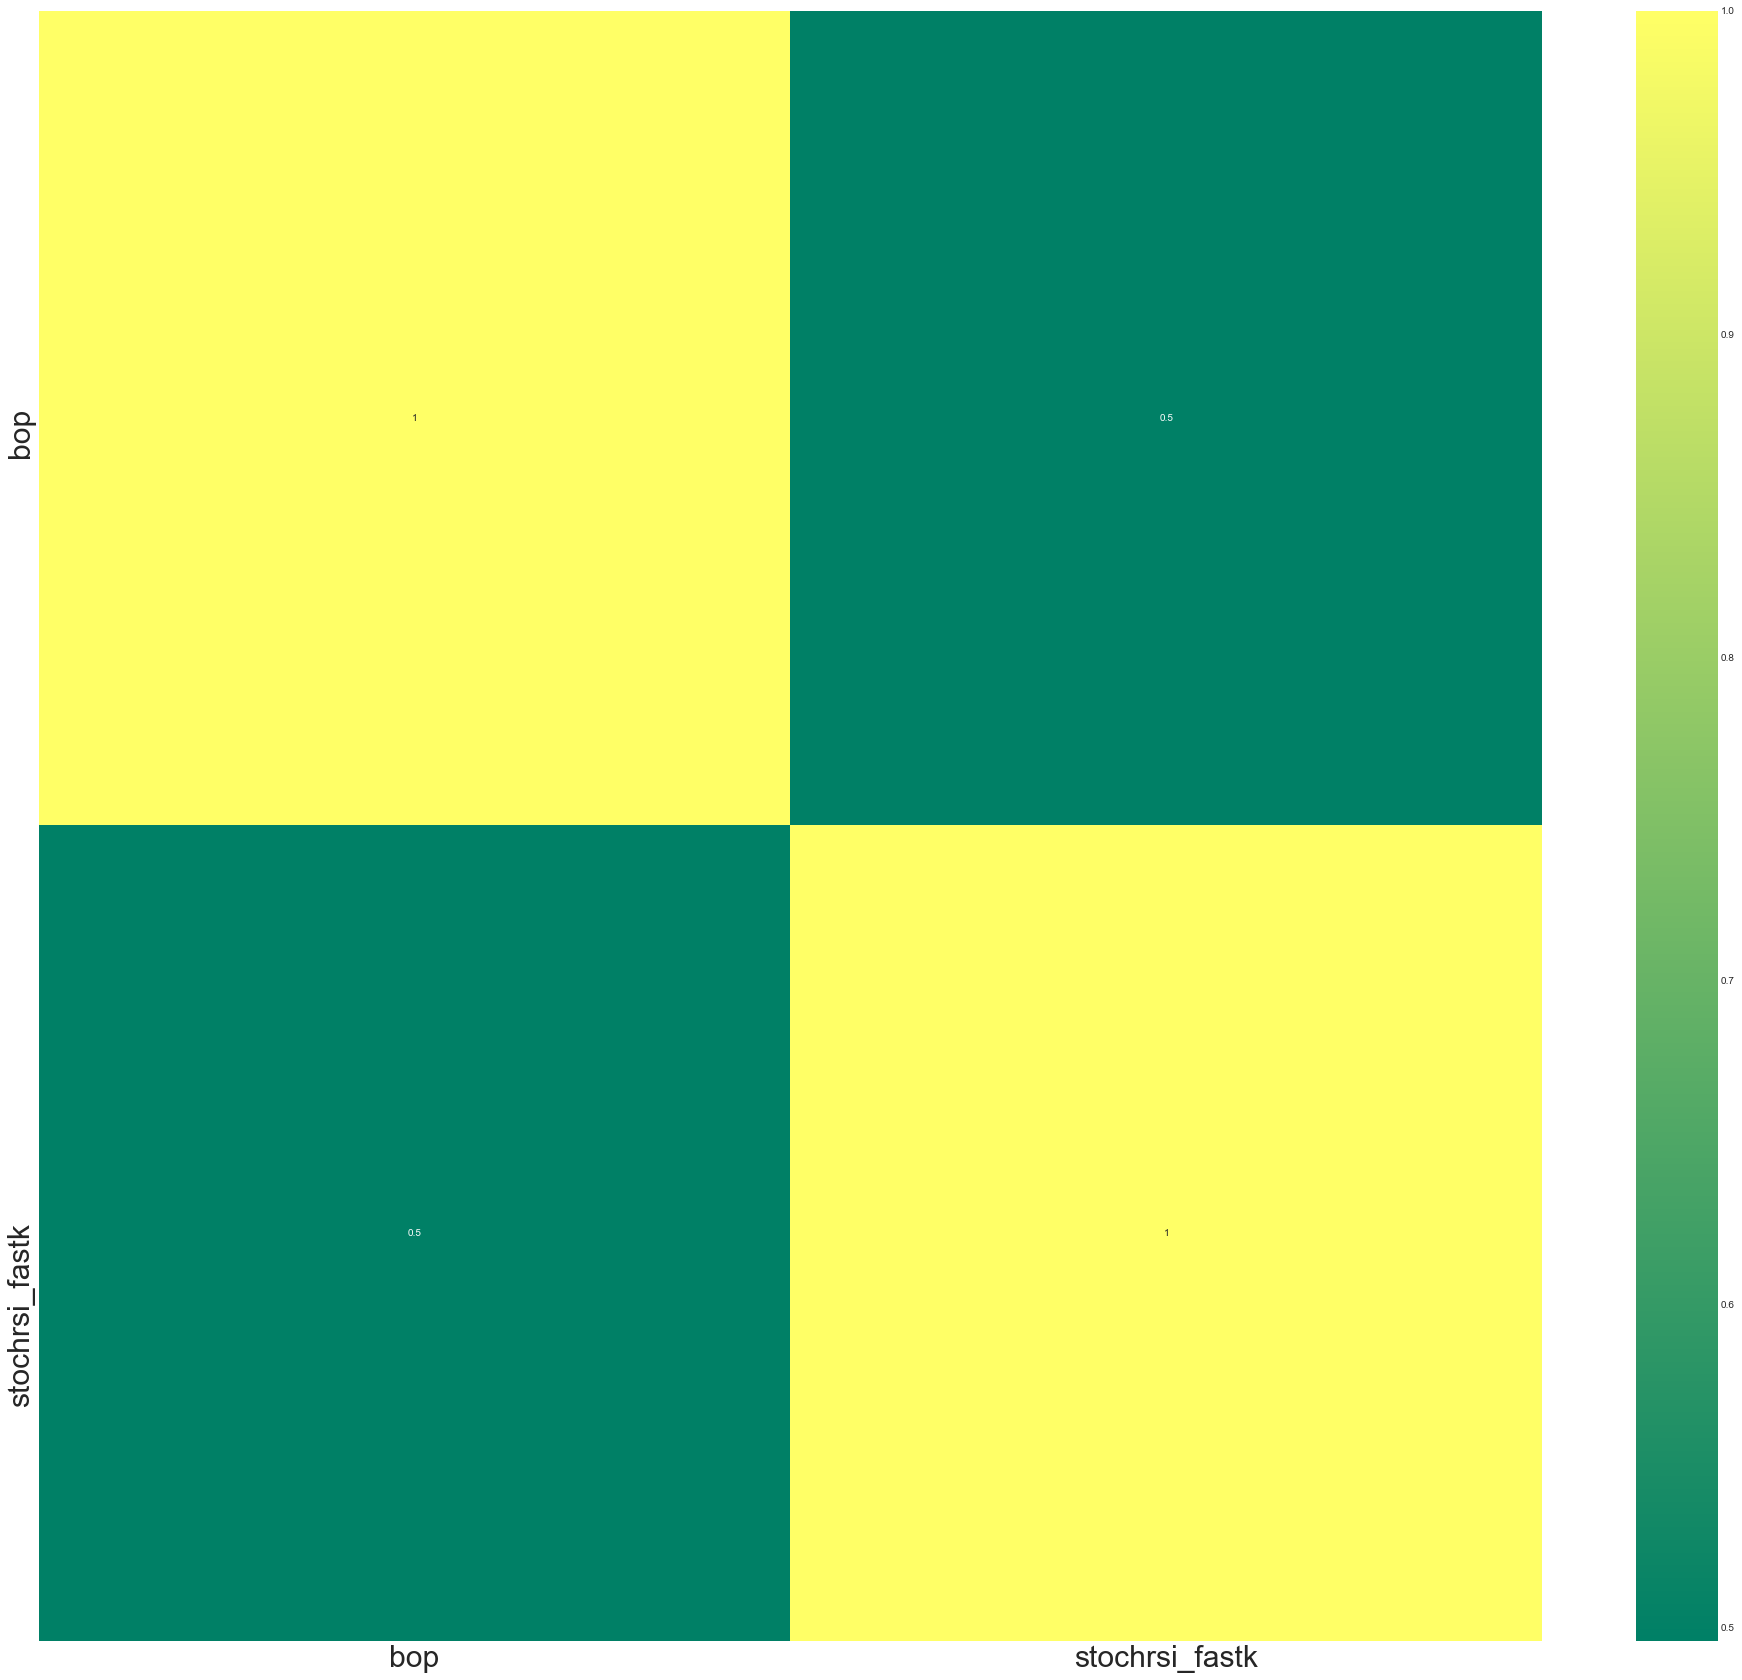

In [16]:
# 4.5 다중공선성 문제 - feature 사이의 관계 찾기 및 처리
for code, df in dic.items() :
    tmp_df = df.loc[:, corrColList].copy()
    corrHeatMap(tmp_df)

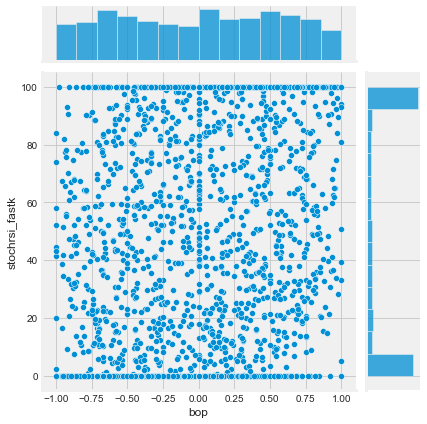

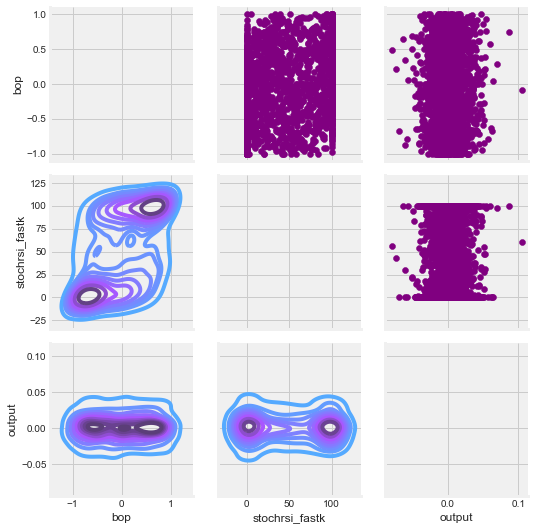

In [17]:
# feature 와 output 과의 상관관계 확인 - reg
addlist = corrColList.copy()
addlist.append('output')

for code, df in dic_reg.items() :
    tmp_df = dic_reg[code].loc[:, addlist].copy()
    simpleCorr(corrColList[0], corrColList[1], tmp_df)
    corrGrid(tmp_df)

In [18]:
# 5. output 과의 관계가 높은 칼럼에 대해 이상치 찾기 - reg
for code, df in dic_reg.items() :
    # 5.5 output 과의 관계가 낮은 칼럼 제거
    df = df.loc[:, addlist]
    dic_reg[code] = df
    for col in corrColList :
        # 이상치를 제거하려면 drop=True 옵션 사용
        outlier(df, col, drop=False)

outlier index length (colNm : bop) : 0
outlier index length (colNm : stochrsi_fastk) : 0


In [19]:
# 5.5 PCA 진행

Best params : {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'random_state': 50}
Best validation score = -0.1269766231080876
mean_squared_error = 0.0003574471765798349


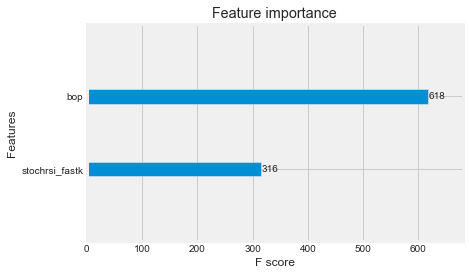

In [34]:
# 값 추측(reg)
for code, df in dic_reg.items() :
    # 6. test-train 분리
    train_df, test_df, valid_df = dataSplitPercent(df)

    # 7. X, y 분리 및 데이터 정규화
    y_train = train_df[outputColNm].copy()
    X_train = scaler(train_df.drop([outputColNm], 1))
    trainTuple = (X_train, y_train)
    
    y_valid = valid_df[outputColNm].copy()
    X_valid = scaler(valid_df.drop([outputColNm], 1))
    validTuple = (X_valid, y_valid)

    y_test = test_df[outputColNm].copy()
    X_test = scaler(test_df.drop([outputColNm], 1))
    testTuple = (X_test, y_test)

    # 8. XGBoost 학습, feature importance 로 중요한 feature 찾기
    paramDic = {}
    paramDic['n_estimators'] = [100, 200]
    paramDic['max_depth'] = [5, 8]
    paramDic['gamma'] = [0]
    paramDic['random_state'] = [50]
    paramDic['learning_rate'] = [0.05, 0.1]
    #paramDic['early_stoppings'] = [100]

    #binaryObj = 'binary:logistic'
    clf = xgBoostGridSearch(trainTuple, validTuple, paramDic, corrColList)
    model = xgBoost(clf, trainTuple, validTuple, corrColList)

    # 9. 예측
    pred(model, testTuple, df, test_df, corrColList)